In [60]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
from qiskit.providers.aer import Aer
from qiskit.quantum_info import random_clifford
import random

In [61]:
n_qubits = 9
T = 4
qr = QuantumRegister(n_qubits, 'q')
cr = ClassicalRegister(n_qubits, 'c')
circ = QuantumCircuit(qr, cr)
p = 0.05

for t in range(T):
    for i in range(n_qubits // 2):
        circ.append(random_clifford(2), [qr[2*i], qr[2*i+1]])
    
    for i in range(n_qubits):
        if random.random() < p:
            circ.measure(qr[i], cr[i])
    
    circ.save_state(pershot = True, label = "t"+str(2*t))

    for j in range((n_qubits - 1) // 2):
        circ.append(random_clifford(2), [qr[2*j+1], qr[2*j+2]])
    
    if n_qubits % 2 == 0:
        circ.append(random_clifford(2), [qr[-1], qr[0]])
    
    for j in range(n_qubits):
        if random.random() < p:
            circ.measure(qr[j], cr[j])

    circ.save_state(pershot = True, label = "t"+str(2*t+1))

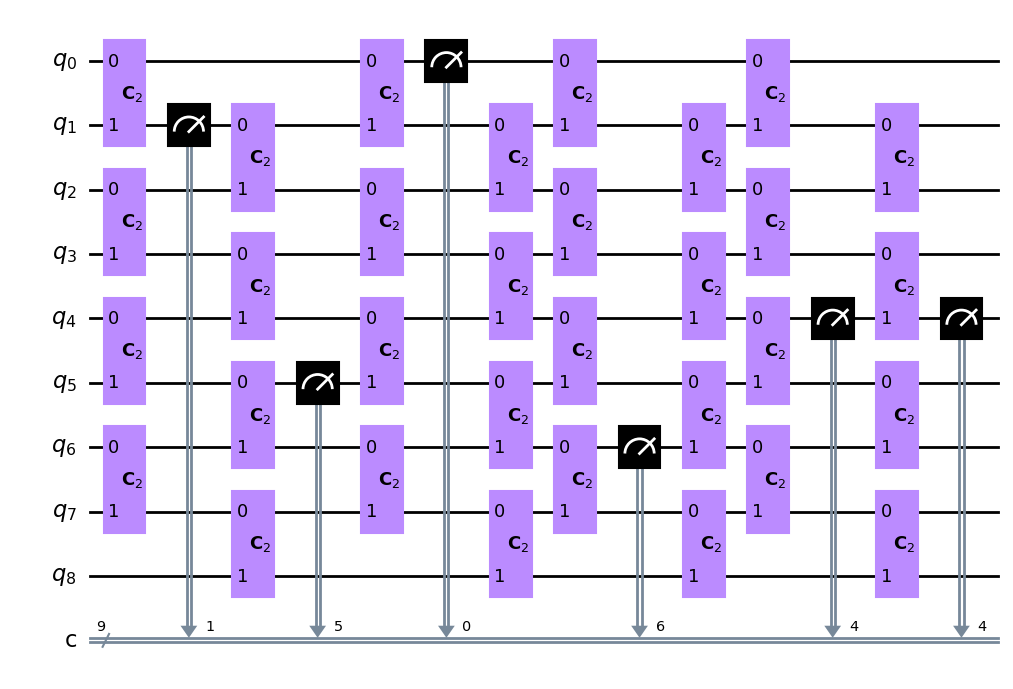

In [62]:
style = {
    'displaytext': {
        'clifford': r'\mathbf{C}_2'
    }
}

circ.draw('mpl', style = style, plot_barriers = False)

In [63]:
simulator = Aer.get_backend('aer_simulator_stabilizer')
circ = transpile(circ, simulator)

In [64]:
# circ.draw('mpl')

In [65]:
result = simulator.run(circ, shots = 10).result()

In [66]:
stabs = result.data()['t7']

In [75]:
test_stab = stabs[0]; test_stab

StabilizerState(StabilizerTable: ['-IIIIZIIII', '+IIYIIZXZX', '+IIIIZZIII', '-IIYIIZZZZ', '-IIYXZZIII', '+XYXYZZXZZ', '+ZXYIIIXXZ', '-YXZZIIZYZ', '+XYYXZZIII'])

In [68]:
cliff = test_stab.clifford

In [69]:
import galois
import numpy as np

In [70]:
GF = galois.GF(2)

In [96]:
stab_2 = GF(cliff.stab.astype(int))[:, :-1]
# Convert from X|Z to xz...xz, and convert to standard order
stab = np.empty_like(stab_2)
stab[:, 0::2] = stab_2[:, n_qubits-1::-1]
stab[:, 1::2] = stab_2[:, :n_qubits-1:-1]

In [97]:
stab_rr = stab.row_reduce() # Pregauge

In [98]:
foo = np.empty_like(stab_rr)
foo[:, 0::2] = stab_rr[:, n_qubits-1::-1]
foo[:, 1::2] = stab_rr[:, :n_qubits-1:-1]
foo = foo.row_reduce()
gauge = np.empty_like(foo)
gauge[:, 0::2] = foo[:, n_qubits-1::-1]
gauge[:, 1::2] = foo[:, :n_qubits-1:-1]

In [99]:
gauge

GF([[1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1],
    [1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
    [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1],
    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], order=2)

In [100]:
def B(G):
    rv = []
    for i in range(n_qubits): # loop through rows
        l = np.inf
        r = -np.inf
        for j in range(n_qubits): # loop through columns
            if G[i, 2*j] == 1 or G[i, 2*j+1] == 1:
                l = min(l, j)
                r = max(r, j)
        rv.append((l, r))
    return np.array(rv)

In [101]:
test_B = B(gauge)

In [102]:
test_B

array([[0, 8],
       [0, 8],
       [0, 6],
       [0, 4],
       [1, 3],
       [1, 8],
       [1, 7],
       [4, 4],
       [0, 0]])